<a href="https://colab.research.google.com/github/salmanromeo/MAE_3403_Computer_Methods_in_Analysis_and_Design/blob/main/lecture_11_Data_Assimilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The ensemble Kalman filter (EnKF) is a Monte-Carlo algorithm for data assimilation that uses an ensemble of short-term forecasts to estimate the background-error covariance in the Kalman filter.**
#####A summary of the EnKF algorithm is described as follows: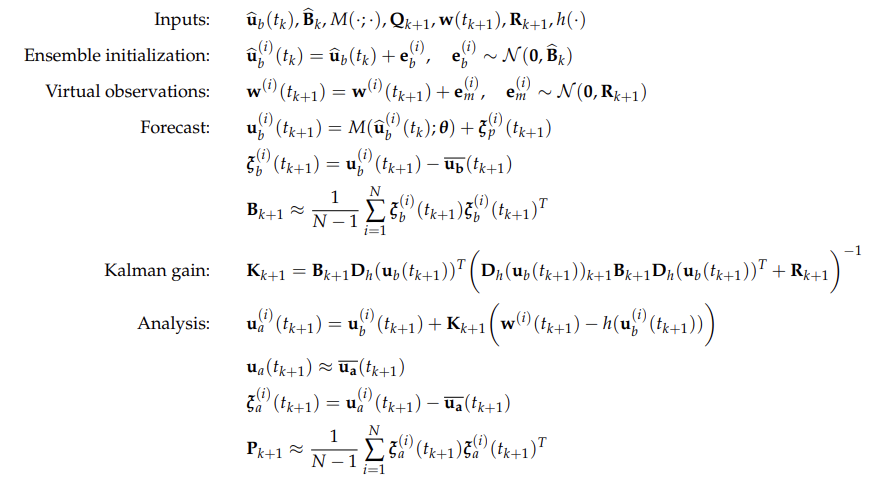

**1D Burgers’ equation**

#####We consider the nonlinear Burgers’ equation:
\begin{align}
  \frac {\partial u}{\partial t} = - u \frac {\partial u}{\partial x} + 𝛎 \frac {\partial^2 u}{\partial x^2}
    \end{align}
#####which is a simple 1D example for the nonlinear convection and diffusion that gives rise to shock waves in fluids.
#####**In lecture 8 (Fast Fourier Transform)**, we wrote a code that uses the **fast Fourier transform (FFT)** to solve the 1D Burgers' equation.
#####Reminder: That code starts by defining the diffusion constant $ν$, the length of the domain $L$, and the number of discretization points $N$. It then defines the discrete wavenumbers $kappa$ using the **np.fft.fftfreq** function and the initial condition $u_0$ as a $sech$ function.

#####The code then sets the time step $dt$ and the time domain $t$, and defines the right-hand side of the Burgers' equation as a function **rhsBurgers**. This function takes as input the state variable $u$, the time $t$, the wavenumbers $kappa$, and the diffusion constant $ν$. It then computes the Fourier transform of $u$ using **np.fft.fft**, applies the first and second derivative operators in Fourier space, and transforms the derivatives back to the spatial domain using **np.fft.ifft**. Finally, it computes the time derivative of $u$ using the Burgers' equation and returns the real part of the result.

#####The code then uses the **odeint** function from the **scipy.integrate** module to solve the Burgers' equation in time, using the **rhsBurgers** function as the right-hand side and passing the wavenumbers and diffusion constant as additional arguments.

**Ensemble Kalman filter (EnKF) solution of Burgers’ equation**

1. **Define the system model:** The system model in this case is the PDE given by the Burgers' equation.

2. **Define the observation operator:** Since we don't have direct observations of the state variables in this case, we need to use an observation operator to obtain the observations. We can define the observation operator as a function that samples the state variables at a few discrete points in space.

3. **Generate an ensemble of initial conditions:** We need to generate a set of initial conditions for the EnKF. We can generate these by randomly perturbing the initial condition given in the code above.

4. **Time integration:** We can use the odeint function in the code above to simulate the PDE forward in time for each member of the ensemble.

5. **Generate observations:** We can use the observation operator defined in step 2 to generate observations at each time step.

6. **Analysis step:** We can use the EnKF algorithm to update the state variables based on the observations generated in step 5.

7. Repeat steps 4-6 for each time step.

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
from numpy.random import normal

plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams.update({'font.size': 11})

# Set up the problem
nu = 0.1                     # Diffusion constant
L = 20                       # Length of domain
N = 100                      # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx)   # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x)

# Simulate PDE in spatial domain
dt = 0.1
t = np.arange(0,100*dt,dt)

def rhsBurgers(u,t,kappa,nu):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    dd_uhat = -np.power(kappa,2)*uhat
    d_u = np.fft.ifft(d_uhat)
    dd_u = np.fft.ifft(dd_uhat)
    du_dt = -u * d_u + nu*dd_u
    return du_dt.real

# Simulate the true system
u_true = odeint(rhsBurgers, u0, t, args=(kappa, nu))

# Set up the EnKF
N_ens = 50                    # Number of ensemble members
perturb = 0.005               # Initial perturbation size

# Initialize the ensemble
u_ens = np.zeros((N_ens, N))
for i in range(N_ens):
    u_ens[i, :] = u_true[0, :] + perturb*normal(size=N)

# Run the EnKF
R = np.eye(N)*0.001          # Measurement error covariance
H = np.eye(N)                # Measurement operator
I = np.eye(N)                # Identity matrix

u_filtered = np.zeros((len(t), N))
u_filtered[0, :] = np.mean(u_ens, axis=0)

for i in range(1, len(t)):
    # Forecast step
    for j in range(N_ens):
        u_ens[j, :] = odeint(rhsBurgers, u_ens[j, :], [t[i-1], t[i]], args=(kappa, nu))[-1, :]
        u_ens[j, :] += perturb*normal(size=N)
    
    # Analysis step
    y = u_true[i, :] + normal(size=N, scale=np.sqrt(R[0, 0]))
    y_ens = np.zeros((N_ens, N))
    for j in range(N_ens):
        y_ens[j, :] = y + normal(size=N, scale=np.sqrt(R[0, 0]))
    y_ens_mean = np.mean(y_ens, axis=0)
    
    K = np.dot(np.dot(np.cov(u_ens.T), H.T), np.linalg.inv(np.dot(np.dot(H, np.cov(u_ens.T)), H.T) + R))
    for j in range(N_ens):
        u_ens[j, :] += np.dot(K, y_ens[j, :] - y_ens_mean)

    # Compute filtered solution
    u_filtered[i, :] = np.mean(u_ens, axis=0)

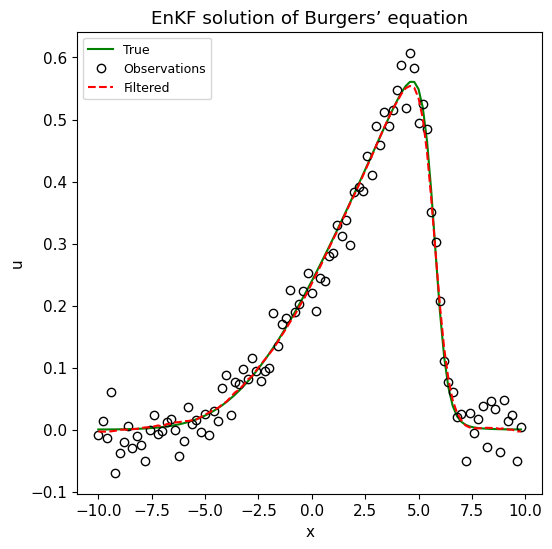

In [118]:
# Plot the results
fig = plt.figure()
plt.plot(x, u_true[-1, :], 'g', label='True')
plt.plot(x, y, 'o', markerfacecolor='none', markeredgecolor='k', label='Observations')
plt.plot(x, u_filtered[-1, :], '--r', label='Filtered')
plt.xlabel('x')
plt.ylabel('u')
plt.title('EnKF solution of Burgers’ equation')
plt.legend(loc='upper left', fontsize=9)
plt.show()

Text(0.5, 1.0, 'EnKF solution of Burgers’ equation over time')

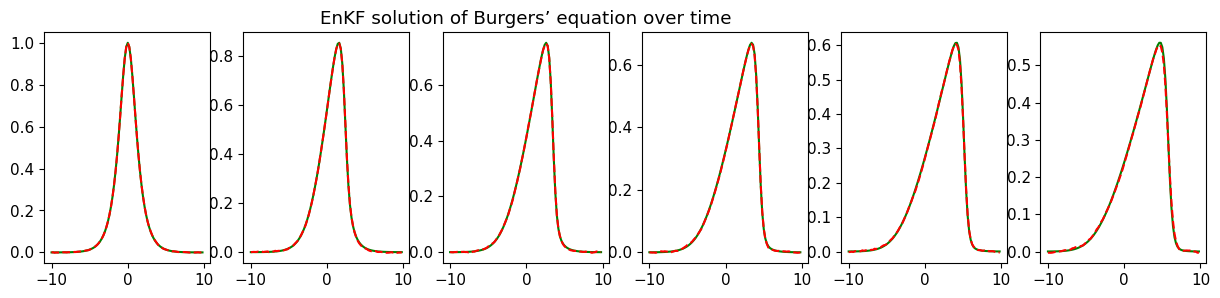

In [127]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(15, 3))
ax1.plot(x, u_true[0, :], 'g', label='True')
ax1.plot(x, u_filtered[0, :], '--r', label='Filtered')
ax2.plot(x, u_true[20, :], 'g', label='True')
ax2.plot(x, u_filtered[20, :], '--r', label='Filtered')
ax3.plot(x, u_true[40, :], 'g', label='True')
ax3.plot(x, u_filtered[40, :], '--r', label='Filtered')
ax4.plot(x, u_true[60, :], 'g', label='True')
ax4.plot(x, u_filtered[60, :], '--r', label='Filtered')
ax5.plot(x, u_true[80, :], 'g', label='True')
ax5.plot(x, u_filtered[80, :], '--r', label='Filtered')
ax6.plot(x, u_true[-1, :], 'g', label='True')
ax6.plot(x, u_filtered[-1, :], '--r', label='Filtered')
ax3.set_title('EnKF solution of Burgers’ equation over time')

**Ensemble Kalman filter (EnKF) solution to the Kuramoto-Sivashinsky equation**

#####The Kuramoto–Sivashinsky (K-S) equation derived by Kuramoto, which is used as a turbulence model for different flows. The one-dimensional K-S equation can be written as:
\begin{align}
  \frac {\partial u}{\partial t} = - 𝛎 \frac {\partial^4 u}{\partial x^4} - \frac {\partial^2 u}{\partial x^2} - u \frac {\partial u}{\partial x}
    \end{align}
#####We impose the Dirichlet boundary conditions as given below:
\begin{align}
  u(0,t)=u(L,t)=0
    \end{align}
#####Using the second-order finite difference discretization, the discretized K-S equation can be written as:
\begin{align}
  \frac {\partial u_i}{\partial t} = -𝛎 \frac {u_{i+2} - 4u_{i+1}+6u_{i}-4u_{i-1}+u_{i-2}}{Δ x^4} - \frac {u_{i+1} -2u_{i}+u_{i-1}}{Δ x^2} - \frac{1}{2} \frac {u_{i+1}^2 -u_{i-1}^2}{2Δx}
    \end{align}

**Generate true solution**

Initial transients...
Forward simulation...


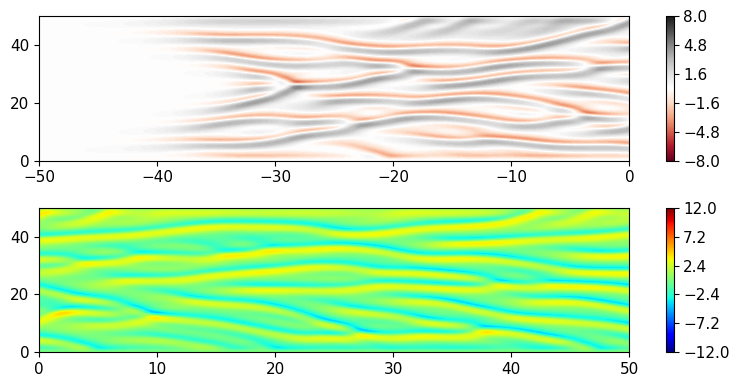

In [133]:
import numpy as np
from numpy.random import seed
seed(1)
from scipy import integrate
from scipy import linalg
import matplotlib.pyplot as plt 
import time as tm
import matplotlib.ticker as ticker
from scipy.integrate import ode
import time as time

#-----------------------------------------------------------------------------#
# define the K-S equation
#-----------------------------------------------------------------------------#
def KSd_dirichlet(t0,u0,v_inv,L):
    v = 1./v_inv
    
    n = np.shape(u0)[0]
    dx = L/(n+1.)
    
    dudt = np.zeros(np.shape(u0))
    
    # -1/2*du^2/dx
    dudt[1:-1] = -(pow(u0[2:],2)-pow(u0[0:-2],2))/4/dx
    dudt[0] = -pow(u0[1],2)/4/dx
    dudt[-1] = pow(u0[-2],2)/4/dx
    
    # -d^2u/dx^2
    dudt[1:-1] = dudt[1:-1]-(u0[0:-2]-2*u0[1:-1]+u0[2:])/pow(dx,2)
    dudt[0] = dudt[0]-(u0[1]-2*u0[0])/pow(dx,2)
    dudt[-1] = dudt[-1]-(u0[-2]-2*u0[-1])/pow(dx,2)
    
    # - d^4u/dx^4
    dudt[2:-2] = dudt[2:-2]-v*(u0[:-4]-4*u0[1:-3]+6*u0[2:-2]-4*u0[3:-1]+u0[4:])/pow(dx,4)
    dudt[0] = dudt[0]-v*(7*u0[0]-4*u0[1]+u0[2])/pow(dx,4)
    dudt[-1] = dudt[-1]-v*(7*u0[-1]-4*u0[-2]+u0[-3])/pow(dx,4)
    dudt[1] = dudt[1]-v*(-4*u0[0]+6*u0[1]-4*u0[2]+u0[3])/pow(dx,4)
    dudt[-2] = dudt[-2]-v*(-4*u0[-1]+6*u0[-2]-4*u0[-3]+u0[-4])/pow(dx,4)
    
    return dudt

#-----------------------------------------------------------------------------#
# parameters
#-----------------------------------------------------------------------------#
ne = 128
L = 50
dx = L/(ne)
F = 0.1            # Forcing

t0 = 0.0
dt = 0.25
tmax = 50.0
tini = 50.0
ns = int(tini/dt)
nt = int(tmax/dt)
v_inv = 2.0
nf = 10           # frequency of observation
nb = int(nt/nf)   # number of observation time

mean = 0.0
sd2 = 1.0e-2         # observation noise (variance)
sd1 = np.sqrt(sd2)   # observation noise (standard deviation)

se2 = 1.0e-2         # model noise (variance)
se1 = np.sqrt(se2)   # model noise (standard deviation)

si2 = 1.0e-2         # initial condition (variance)
si1 = np.sqrt(si2)   # initial condition (standard deviation)

# number of observation vector
me = 64
freq = int(ne/me)
oin = [freq*i-1 for i in range(1,me+1)]

# number of ensemble 
npe = 40

oib = [nf*k for k in range(nb+1)]

#%%
utrue = np.zeros((ne+1,nt+1))
uinit = np.zeros((ne+1,ns+1))

#-----------------------------------------------------------------------------#
# generate true solution trajectory
#-----------------------------------------------------------------------------#
ti = np.linspace(-tini,0,ns+1)
t = np.linspace(0,tmax,nt+1)
tobs = np.linspace(0,tmax,nb+1)
x = np.linspace(0,L,ne+1)

X,T = np.meshgrid(x,t,indexing='ij')
Xi,Ti = np.meshgrid(x,ti,indexing='ij')

u = F*np.ones((ne-1,1))            # np.cos(x/16)*(1.0 + np.sin(x/16))
uinit[1:-1,0] = np.reshape(u, (-1))

r = ode(KSd_dirichlet).set_integrator('lsoda', nsteps=5000)

print("Initial transients...")
for k in range(1,ns+1):
    u = uinit[1:-1,k-1]
    u = np.reshape(u,[-1,1])
    r.set_initial_value(u, t0).set_f_params(v_inv,L)
    r.integrate(r.t+dt)
    uinit[1:-1,k] = np.reshape(r.y, (-1))
    

# assign inital condition
u = uinit[1:-1,-1]
utrue[1:-1,0] = u

print("Forward simulation...")
# generate true forward solution
for k in range(1,nt+1):
    u = utrue[1:-1,k-1]
    u = np.reshape(u,[-1,1])
    r.set_initial_value(u, t0).set_f_params(v_inv,L)
    r.integrate(r.t+dt)
    utrue[1:-1,k] = np.reshape(r.y, (-1))

vmin = -8
vmax = 8
fig, ax = plt.subplots(2,1,figsize=(8,4))
cs = ax[0].contourf(Ti,Xi,uinit,60,cmap='RdGy',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='RdGy')
m.set_array(uinit)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

vmin = -12
vmax = 12
cs = ax[1].contourf(T,X,utrue,60,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

**Generate observations**

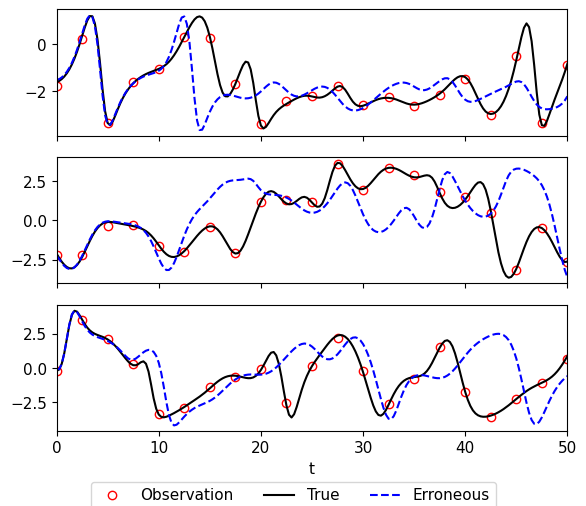

In [135]:
#-----------------------------------------------------------------------------#
# generate observations
#-----------------------------------------------------------------------------#
uobs = utrue[:,oib] + np.random.normal(mean,sd1,[ne+1,nb+1])

#-----------------------------------------------------------------------------#
# generate erroneous soltions trajectory
#-----------------------------------------------------------------------------#
uw = np.zeros((ne+1,nt+1))
k = 0

u = utrue[1:-1,0] + np.random.normal(mean,si1,ne-1)
uw[1:-1,0] = u

for k in range(1,nt+1):
    u = uw[1:-1,k-1]
    u = np.reshape(u,[-1,1])
    r.set_initial_value(u, t0).set_f_params(v_inv,L)
    r.integrate(r.t+dt)
    uw[1:-1,k] = np.reshape(r.y, (-1))

fig, ax = plt.subplots(3,1,sharex=True,figsize=(6,5))
n = [4,14,34]
for i in range(3):
    ax[i].plot(tobs,uobs[n[i],:],'ro', lw=3,fillstyle='none',markersize=6)
    ax[i].plot(t,utrue[n[i],:],'k-')
    ax[i].plot(t,uw[n[i],:],'b--')

    ax[i].set_xlim([0,tmax])

ax[i].set_xlabel('t')
line_labels = ['Observation','True','Erroneous',]
plt.figlegend( line_labels,  loc = 'lower center', borderaxespad=-0.2, ncol=4, labelspacing=0.)
fig.tight_layout()
plt.show()

**EnKF model**

In [136]:
#-----------------------------------------------------------------------------#
# EnKF model
#-----------------------------------------------------------------------------#    
cn = 1.0/np.sqrt(npe-1)

z = np.zeros((me,nb+1))
zf = np.zeros((me,npe,nb+1))
DhX = np.zeros((me,npe))
DhXm = np.zeros(me)

ua = np.zeros((ne+1,nt+1))     # mean analyssi solution (to store)
uf = np.zeros(ne+1)            # mean forecast
sc = np.zeros((ne+1,npe))      # square-root of the covariance matrix
ue = np.zeros((ne+1,npe,nt+1)) # all ensambles
ph = np.zeros((ne+1,me))

km = np.zeros((ne+1,me))
kmd = np.zeros((ne+1,npe))

cc = np.zeros((me,me))
ci = np.zeros((me,me))

for k in range(nb+1):
    z[:,k] = uobs[oin,k]
    for n in range(npe):
        zf[:,n,k] = z[:,k] + np.random.normal(mean,sd1,me)

start = time.time()
# initial ensemble
k = 0

for n in range(npe):
    ue[1:-1,n,k] = uw[1:-1,k] + np.random.normal(mean,si1,ne-1)       
    
ua[:,k] = np.sum(ue[:,:,k],axis=1)
ua[:,k] = ua[:,k]/npe

kobs = 1

# RK4 scheme
for k in range(1,nt+1):
    
    # forecast afor all ensemble fields
    for n in range(npe):
        u = ue[1:-1,n,k-1]
        u = np.reshape(u,[-1,1])
        r.set_initial_value(u, t0).set_f_params(v_inv,L)
        r.integrate(r.t+dt)
        ue[1:-1,n,k] = np.reshape(r.y, (-1)) + np.random.normal(mean,se1,ne-1)
    
    if k == oib[kobs]:
        print(oib[kobs])
        # compute mean of the forecast fields
        uf[:] = np.sum(ue[:,:,k],axis=1)   
        uf[:] = uf[:]/npe
        
        # compute square-root of the covariance matrix
        for n in range(npe):
            sc[:,n] = cn*(ue[:,n,k] - uf[:]) # sc ==> X'
        
        # compute DhXm data
        DhXm[:] = np.sum(ue[oin,:,k],axis=1)    
        DhXm[:] = DhXm[:]/npe
        
        # compute DhM data
        for n in range(npe):
            DhX[:,n] = cn*(ue[oin,n,k] - DhXm[:])
            
        # R = sd2*I, observation m+atrix
        cc = DhX @ DhX.T # cc ==> HPH 
        
        for i in range(me):
            cc[i,i] = cc[i,i] + sd2 # cc ==> HPH + R
        
        ph = sc @ DhX.T # ph ==> (Pf) (Dh)
                    
        ci = np.linalg.pinv(cc) # ci: inverse of cc matrix
        
        km = ph @ ci
        
        # analysis update    
        kmd = km @ (zf[:,:,kobs] - ue[oin,:,k])
        ue[:,:,k] = ue[:,:,k] + kmd[:,:]
        
        kobs = kobs+1
    
    # mean analysis for plotting
    ua[:,k] = np.sum(ue[:,:,k],axis=1)
    ua[:,k] = ua[:,k]/npe

cpu_time = time.time() - start
print('CPU time = ', cpu_time)

np.savez('data_s_'+str(me)+'.npz',t=t,tobs=tobs,T=T,X=X,utrue=utrue,uobs=uobs,
         uw=uw,ua=ua,oin=oin,cpu_time=cpu_time)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
CPU time =  463.5402090549469


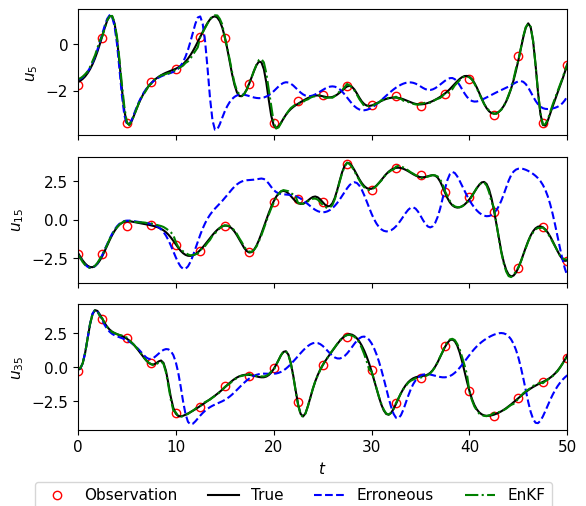

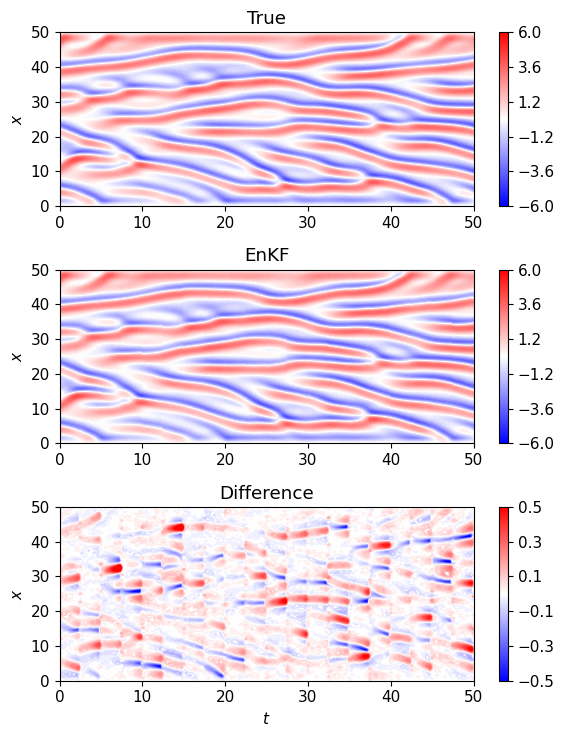

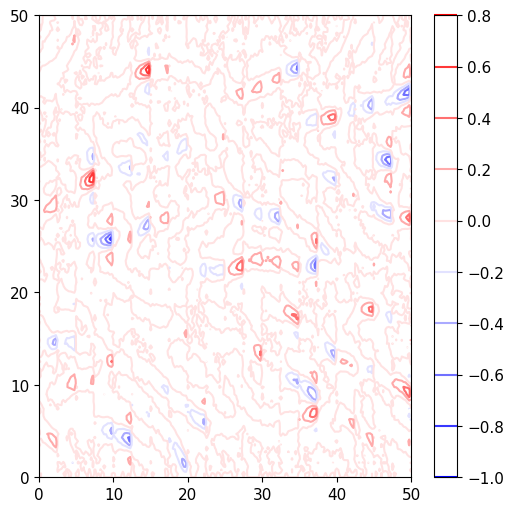

In [137]:
fig, ax = plt.subplots(3,1,sharex=True,figsize=(6,5))

n = [4,14,34]
for i in range(3):
    ax[i].plot(tobs,uobs[n[i],:],'ro', lw=3,fillstyle='none',markersize=6)
    ax[i].plot(t,utrue[n[i],:],'k-')
    ax[i].plot(t,uw[n[i],:],'b--')
    ax[i].plot(t,ua[n[i],:],'g-.')

    ax[i].set_xlim([0,tmax])
    ax[i].set_ylabel(r'$u_{'+str(n[i]+1)+'}$')

ax[i].set_xlabel(r'$t$')
line_labels = ['Observation','True','Erroneous','EnKF']
plt.figlegend( line_labels,  loc = 'lower center', borderaxespad=-0.2, ncol=4, labelspacing=0.)
fig.tight_layout()
plt.show() 
fig.savefig('ms_'+str(me)+'.eps')

vmin = -6
vmax = 6
fig, ax = plt.subplots(3,1,figsize=(6,7.5))

cs = ax[0].contourf(T,X,utrue,60,cmap='bwr',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
ax[0].set_title('True')
ax[0].set_ylabel(r'$x$')

cs = ax[1].contourf(T,X,ua,60,cmap='bwr',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_array(ua)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
ax[1].set_title('EnKF')
ax[1].set_ylabel(r'$x$')

diff = utrue - ua
vmin = -0.5
vmax = 0.5
cs = ax[2].contour(T,X,diff ,60,cmap='bwr',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_array(ua)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))
ax[2].set_title('Difference')
ax[2].set_xlabel(r'$t$')
ax[2].set_ylabel(r'$x$')

fig.tight_layout()
plt.show() 
fig.savefig('fd_'+str(me)+'.eps')

cs = plt.contour(T,X,diff, 10,cmap='bwr')

# add default colorbar for the map
plt.colorbar(cs)
plt.show()